# Lossy Compression 

Experiments with lossy compression of netCDF files.

In the first example, I took an arbitrary file `b.e21.BSSP370cmip6.f09_g17.CMIP6-SSP3-7.0.101.cam.h0.TS.206501-210012.nc` which I had stored locally. It was stored as `netCDF-4 classic model` (according to `ncdump -k`) and was 51MB. 

Following the instructions on NCO's documentation, I applied lossy compression:
```
ncks -4 -L 1 --ppc default=5 b.e21.BSSP370cmip6.f09_g17.CMIP6-SSP3-7.0.101.cam.h0.TS.206501-210012.nc compressed/b.e21.BSSP370cmip6.f09_g17.CMIP6-SSP3-7.0.101.cam.h0.TS.206501-210012.nc
```
The result was a `netCDF-4` file that was 28MB. 

For comparison, I also ran `ncks -4 -L 1` on the file and confirmed that it must have already been losslessly compressed because it was still 51MB.

## Comparing the files

In the following, I will load these two files to look for differences. 

## Modified Approach
Based on initial results that looked like compression had negligible impact on basic statistics, I wanted to double check with other variables.

I used a directory of assorted netCDF files (basically a downloads folder for temporary data), and made compressed versions of all of them. I modified the code so that the files are specified and a variable name is specified, and then the calculations are performed regardless of the inputs. 


In [23]:
import xarray as xr
from time import perf_counter
from pathlib import Path

In [24]:
def printMinMaxMean(darr):
    return f"Min: {darr.min().item()}, Max: {darr.max().item()}, Mean: {darr.mean().item()}"

In [50]:
fname = "CAM6_GCM_RCE_large305_2D_clwvi.nc"
# "era5_month_surfacepressure.nc" # this one is tricky b/c there's an extra dimension
#"b.e15.B5505C5WCCML45BGC.cam5_4.1980_2010.001.cam.h0.U.200002-201001.nc" 
#"F1850JJB_c201_CTL.cam.h2.ncrcat.PRECT.nc"

oloc = Path("/Volumes/Samsung_T5/stray_nc")
cloc = oloc / "compressed"
ofil = oloc / fname
cfil = cloc / fname

t1_start = perf_counter()
ods = xr.open_dataset(ofil)
# Stop the stopwatch / counter
t1_stop = perf_counter()
print("Elapsed time:", t1_stop, t1_start)
print("Elapsed time during the whole program in seconds:",
                                        t1_stop-t1_start)
t1_start = perf_counter()
cds = xr.open_dataset(cfil)
# Stop the stopwatch / counter
t1_stop = perf_counter()
print("Elapsed time:", t1_stop, t1_start)
print("Elapsed time during the whole program in seconds:",
                                        t1_stop-t1_start)


# take a look at the data_vars:

print(f"Data Vars: {ods.data_vars}")
print(cds.coords)


variable = "clwvi" # "sp" # "PRECT"

variable_scales = {"PRECT": 86400. * 1000., "U":1, "sp":1, "clwvi":1}

Elapsed time: 341222.663453862 341222.044551587
Elapsed time during the whole program in seconds: 0.618902274989523
Elapsed time: 341222.749768174 341222.663690262
Elapsed time during the whole program in seconds: 0.08607791201211512
Data Vars: Data variables:
    clwvi    (time, lat, lon) float32 ...
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2000-01-01 00:00:00 ... 2003-01-01 00:00:00


In [51]:
t2_start = perf_counter()
x0 = ods[variable] * variable_scales[variable]
t2_stop = perf_counter()
print(f"Read time (lossless): {t2_stop - t2_start}")

t3_start = perf_counter()
x1 = cds[variable] * variable_scales[variable]
t3_stop = perf_counter()
print(f"Read time (lossy): {t3_stop - t3_start}")

Read time (lossless): 35.09617028204957
Read time (lossy): 65.00456678902265


In [52]:
t4_start = perf_counter()
difference = x1 - x0
t4_step1 = perf_counter()
print(f"Difference took: {t4_step1 - t4_start}")
print(f"DIFFERENCE: Min: {difference.min().item()}, Max {difference.max().item()}, Mean: {difference.mean().item()}")
climo0 = x0.mean(dim='time')
climo1 = x1.mean(dim='time')
dclimo = climo1 - climo0
print(f"CLIMO DIFFERENCE: Min: {dclimo.min().item()}, Max {dclimo.max().item()}, Mean: {dclimo.mean().item()} ")

Difference took: 40.365916363021825
DIFFERENCE: Min: -3.039836883544922e-05, Max 3.0517578125e-05, Mean: 2.477299698711022e-09
CLIMO DIFFERENCE: Min: -2.384185791015625e-07, Max 2.4586915969848633e-07, Mean: 2.979235080857734e-09 


In [53]:
timevar0 = x0.var(dim='time')
timevar1 = x1.var(dim='time')
dvar = timevar1 - timevar0
print(f"Original Temporal Variance: {printMinMaxMean(timevar0)}")
print(f"Temporal Variance DIFFERENCE: {printMinMaxMean(dvar)}")

Original Temporal Varaince: Min: 0.0018513817340135574, Max: 0.04825529828667641, Mean: 0.015544640831649303
Temporal Variance DIFFERENCE: Min: -6.332993507385254e-08, Max: 7.82310962677002e-08, Mean: 1.3795181663667222e-09


In [54]:
import numpy as np
if ("lat" not in x0.dims) and ("latitude" in x0.dims):
    x0 = x0.rename({"latitude":"lat", "longitude":"lon"})
if ("lat" not in x1.dims) and ("latitude" in x1.dims):
    x1 = x1.rename({"latitude":"lat", "longitude":"lon"})
if ("lat" not in difference.dims) and ("latitude" in difference.dims):
    difference = difference.rename({"latitude":"lat", "longitude":"lon"})
gavg0 = x0.weighted(np.cos(np.radians(x0['lat']))).mean(dim=("lat","lon"))
gavg1 = x1.weighted(np.cos(np.radians(x1['lat']))).mean(dim=("lat","lon"))
dgavg = gavg1 - gavg0
print(f"Original Global Average: {printMinMaxMean(gavg0)}")
print(f"Global Avg Difference: {printMinMaxMean(dgavg)}")

Original Global Average: Min: 0.0, Max: 0.08718844251537508, Mean: 0.06624645931795305
Global Avg Difference: Min: -1.435947244443625e-08, Max: 2.3258428419326016e-08, Mean: 2.8329771642810448e-09


In [55]:
gavg1

<xarray.DataArray 'clwvi' (time: 26281)>
array([0.        , 0.        , 0.00135946, ..., 0.06096728, 0.06028973,
       0.05959598])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2003-01-01 00:00:00

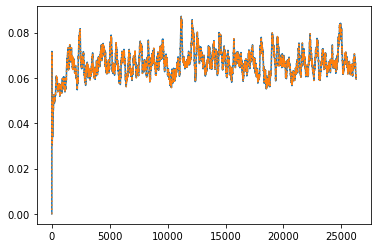

In [56]:
import matplotlib.pyplot as plt

plt.plot(gavg0)
plt.plot(gavg1, ":")

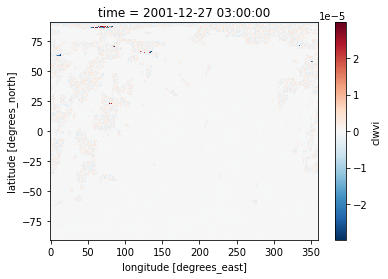

In [57]:
# example of the difference
# each level as needed, random time
rng = np.random.default_rng()
tsel = rng.integers(0,len(x1.time))
if "lev" in x1.dims:
    for ilev in x1['lev']:
        difference.sel(lev=ilev).isel(time=tsel).plot.pcolormesh()
        plt.show()
else:
    difference.isel(time=tsel).plot.pcolormesh()

## Conclusion
Based on this simple comparison, it appears that this relatively modest compression approach is acceptable. The compression reduced the file size by almost half, but the impacts on the values appear negligible. Also important, there does not appear to be a penalty in terms of access time. 